In [1]:
import sys
import os

# 获取当前 Notebook 的路径
current_dir = os.path.dirname(os.path.abspath("__file__"))

# 获取上一级目录
parent_dir = os.path.dirname(current_dir)

# 添加上一级目录到 sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import read_jsonl

In [3]:
import os
import time
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from functools import partial
from eap.metrics import logit_diff
from eap.graph import Graph
from eap.dataset import EAPDataset
from eap.attribute import attribute
from eap.evaluate import evaluate_graph, evaluate_baseline, get_circuit_logits

In [4]:
revised_entity_first_token_accuracy = [
    0.391347099,
    0.392330383,
    0.392330383,
    0.36086529,
    0.392330383,
    0.368731563,
    0.385447394,
    0.416912488,
    0.456243854,
    0.48574238,
    0.499508358,
    0.608652901,
    0.638151426,
    0.670599803,
    0.693215339,
    0.739429695,
    0.752212389,
    0.777777778,
    0.799410029,
    0.807276303,
    0.821042281,
    0.840707965,
    0.848574238,
    0.87020649,
    0.862340216,
    0.871189774,
    0.886922321,
    0.89380531,
    0.888888889,
    0.897738446,
    0.903638151,
    0.914454277,
    0.910521141,
    0.912487709,
    0.92920354,
    0.931170108,
    0.935103245,
    0.937069813,
    0.949852507,
    0.961651917,
    0.958702065,
    0.949852507,
    0.955752212,
    0.967551622,
    0.962635202,
    0.955752212,
    0.959685349,
    0.959685349,
    0.966568338,
    0.967551622,
    0.970501475,
    0.971484759,
    0.975417896,
    0.969518191,
    0.968534907,
    0.970501475,
    0.965585054,
    0.973451327,
    0.968534907,
    0.968534907,
    0.975417896,
    0.975417896,
    0.977384464,
    0.978367748,
    0.968534907,
    0.981317601,
    0.97640118,
    0.980334317,
    0.981317601,
    0.978367748,
    0.97640118,
    0.978367748,
    0.971484759,
    0.979351032,
    0.978367748,
    0.979351032,
    0.984267453,
    0.982300885,
    0.981317601,
    0.97640118
]

In [5]:
new_entity_first_token_accuracy = [
    0.36847315,
    0.367978223,
    0.36847315,
    0.368968077,
    0.368720614,
    0.369710468,
    0.370947785,
    0.376144519,
    0.386537986,
    0.406087602,
    0.415738679,
    0.456075229,
    0.487503093,
    0.524622618,
    0.560999753,
    0.604553328,
    0.625835189,
    0.664934422,
    0.673100718,
    0.69660975,
    0.719623855,
    0.741400643,
    0.755258599,
    0.773570898,
    0.78148973,
    0.800791883,
    0.813907449,
    0.829992576,
    0.837663945,
    0.854738926,
    0.853501609,
    0.85572878,
    0.868844345,
    0.877505568,
    0.882454838,
    0.88616679,
    0.883692155,
    0.900519673,
    0.901756991,
    0.912150458,
    0.918831972,
    0.914130166,
    0.931205147,
    0.932689928,
    0.936896808,
    0.938876516,
    0.942835932,
    0.949517446,
    0.95545657,
    0.962385548,
    0.956693888,
    0.964860183,
    0.96461272,
    0.969809453,
    0.964365256,
    0.966097501,
    0.962385548,
    0.971789161,
    0.965107647,
    0.968572136,
    0.969067063,
    0.971541698,
    0.969314526,
    0.969809453,
    0.972036625,
    0.974263796,
    0.970799307,
    0.969314526,
    0.970551844,
    0.976243504,
    0.97451126,
    0.975748577,
    0.973273942,
    0.974016333,
    0.972779015,
    0.971541698,
    0.969809453,
    0.972531552,
    0.975501114,
    0.977728285
]

In [6]:
x_coords = np.arange(len(new_entity_first_token_accuracy)) / (len(new_entity_first_token_accuracy) - 1) * 9

In [7]:
directory_path="../outputs/train/TinyLlama_v1.1/2024-12-20-09-42-42/checkpoints"
subdirectories = [
    name for name in os.listdir(directory_path)
    if os.path.isdir(os.path.join(directory_path, name))
]

In [8]:
new_entity_result_matrix = []
revised_entity_result_matrix = []
to_delete = []
for dir_name in subdirectories:
    prediction_file = os.path.join(directory_path, dir_name, "prediction.jsonl")
    if not os.path.exists(prediction_file):
        print(f"Prediction file not found for directory '{dir_name}'")
        to_delete.append(dir_name)
    else:
        print(f"Reading prediction file for directory '{dir_name}'")
        predictions = read_jsonl(prediction_file)
        N = len(predictions)
        new_entity_num = int(0.5 * N)
        new_entity_result = [pred["correct"] for pred in predictions][:new_entity_num]
        new_entity_result_matrix.append(new_entity_result)
        revised_entity_result = [pred["correct"] for pred in predictions][new_entity_num:]
        revised_entity_result_matrix.append(revised_entity_result)

for dir_name in to_delete:
    subdirectories.remove(dir_name)

Reading prediction file for directory 'checkpoint-400'
Reading prediction file for directory 'checkpoint-2001'
Reading prediction file for directory 'checkpoint-1200'
Reading prediction file for directory 'checkpoint-3602'
Reading prediction file for directory 'checkpoint-2801'
Reading prediction file for directory 'checkpoint-800'
Reading prediction file for directory 'checkpoint-2401'
Reading prediction file for directory 'checkpoint-4000'
Reading prediction file for directory 'checkpoint-1601'
Reading prediction file for directory 'checkpoint-3202'


In [9]:
indexes = sorted(range(len(subdirectories)), key=lambda i: int(subdirectories[i].split('-')[1]))

print("排序后的下标列表：", indexes)

排序后的下标列表： [0, 5, 2, 8, 1, 6, 4, 9, 3, 7]


In [10]:
new_entity_result_matrix = [new_entity_result_matrix[i] for i in indexes]
new_entity_result_matrix = np.array(new_entity_result_matrix)
revised_entity_result_matrix = [revised_entity_result_matrix[i] for i in indexes]
revised_entity_result_matrix = np.array(revised_entity_result_matrix)

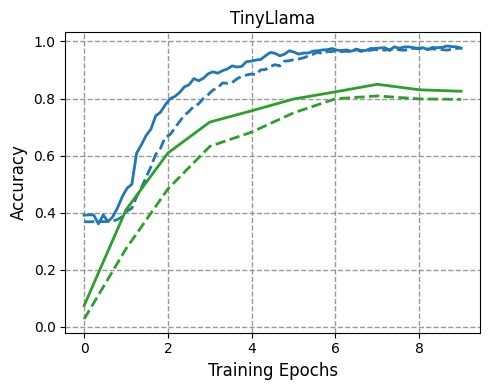

In [11]:
new_entity_accuracy = np.mean(new_entity_result_matrix, axis=1)
revised_entity_accuracy = np.mean(revised_entity_result_matrix, axis=1)

plt.figure(figsize=(5, 4))
plt.plot(x_coords, revised_entity_first_token_accuracy, label='First-token Acc (K_rel)', linewidth=2, color='C0')
plt.plot(x_coords, new_entity_first_token_accuracy, label='First-token Acc (K_compl)', linewidth=2, color='C0', linestyle='--')
plt.plot(revised_entity_accuracy, label='Query Acc (K_rel)', linewidth=2, color='C2')
plt.plot(new_entity_accuracy, label='Query Acc (K_compl)', linewidth=2, color='C2', linestyle='--')

plt.title('TinyLlama')
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

# # Annotate each point with its accuracy value
# for i, accuracy in enumerate(new_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

# for i, accuracy in enumerate(revised_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

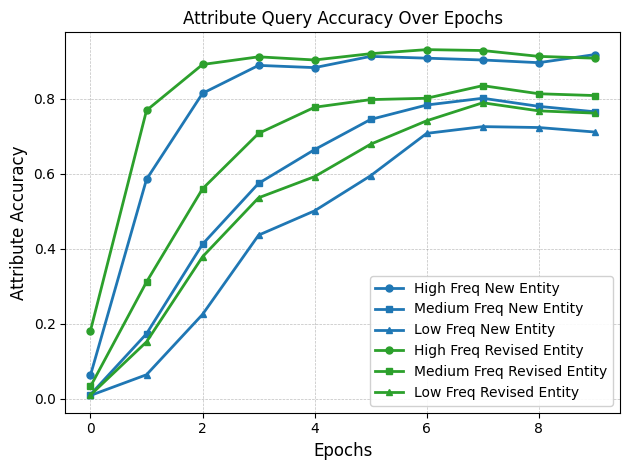

In [12]:
num_columns = new_entity_result_matrix.shape[1]  # 获取列数
num_columns_to_average = num_columns // 3

high_new_entity_accuracy = np.mean(new_entity_result_matrix[:, :num_columns_to_average], axis=1)
high_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, :num_columns_to_average], axis=1)

medium_new_entity_accuracy = np.mean(new_entity_result_matrix[:, num_columns_to_average: 2*num_columns_to_average], axis=1)
medium_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, num_columns_to_average: 2*num_columns_to_average], axis=1)

low_new_entity_accuracy = np.mean(new_entity_result_matrix[:, -num_columns_to_average:], axis=1)
low_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, -num_columns_to_average:], axis=1)


plt.plot(high_new_entity_accuracy, label='High Freq New Entity', color='C0', marker='o', linewidth=2, markersize=5)
plt.plot(medium_new_entity_accuracy, label='Medium Freq New Entity', color='C0', marker='s', linewidth=2, markersize=5)
plt.plot(low_new_entity_accuracy, label='Low Freq New Entity', color='C0', marker='^', linewidth=2, markersize=5)

plt.plot(high_revised_entity_accuracy, label='High Freq Revised Entity', color='C2', marker='o', linewidth=2, markersize=5)
plt.plot(medium_revised_entity_accuracy, label='Medium Freq Revised Entity', color='C2', marker='s', linewidth=2, markersize=5)
plt.plot(low_revised_entity_accuracy, label='Low Freq Revised Entity', color='C2', marker='^', linewidth=2, markersize=5)

plt.title('Attribute Query Accuracy Over Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Attribute Accuracy', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# # Annotate each point with its accuracy value
# for i, accuracy in enumerate(new_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

# for i, accuracy in enumerate(revised_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [13]:
def reduce_array(arr, n):
    """
    将有序数组的元素减少到 n 个，均匀删减元素。

    参数:
    - arr: 原始有序数组
    - n: 缩减后的元素数量

    返回:
    - 新的缩减后数组
    """
    N = len(arr)
    if n >= N:
        return arr  # 如果需要的元素数量大于或等于原数组数量，则返回原数组

    # 计算步长 step，确保均匀删减
    step = N / n

    # 保留均匀分布的 n 个元素
    reduced_arr = [arr[int(i * step)] for i in range(n)]

    return reduced_arr

In [14]:
n = 1000
ensembeld_new_entity_result_matrix = [[sum(reduce_array(line, n)[i:i + 5]) for i in range(0, n, 5)] for line in new_entity_result_matrix]
ensembeld_new_entity_result_matrix = np.array(ensembeld_new_entity_result_matrix)
ensembeld_new_entity_result_matrix.shape

(10, 200)

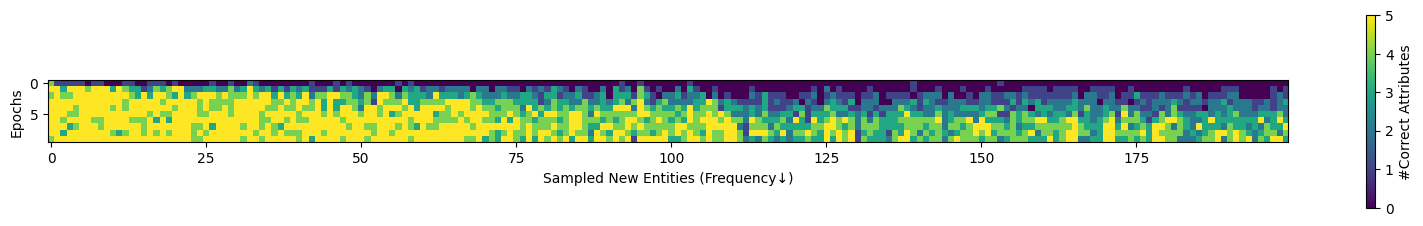

In [15]:
plt.figure(figsize=(20, 2.5))  # 调整宽度和高度
plt.imshow(ensembeld_new_entity_result_matrix, cmap='viridis', interpolation='nearest')
plt.ylabel('Epochs')
plt.xlabel('Sampled New Entities (Frequency↓)')
plt.colorbar().set_label('#Correct Attributes')
plt.show()

In [16]:
ensembeld_revised_entity_result_matrix = [[sum(reduce_array(line, n)[i:i + 5]) for i in range(0, n, 5)] for line in revised_entity_result_matrix]
ensembeld_revised_entity_result_matrix = np.array(ensembeld_revised_entity_result_matrix)
ensembeld_revised_entity_result_matrix.shape

(10, 200)

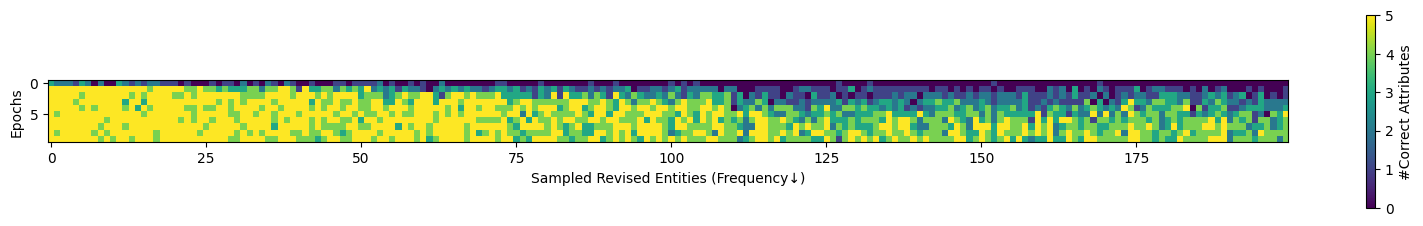

In [17]:
plt.figure(figsize=(20, 2.5))  # 调整宽度和高度
plt.imshow(ensembeld_revised_entity_result_matrix, cmap='viridis', interpolation='nearest')
plt.ylabel('Epochs')
plt.xlabel('Sampled Revised Entities (Frequency↓)')
plt.colorbar().set_label('#Correct Attributes')
plt.show()

In [18]:
hit_at_10_results = {
    "new": {
        "high": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "medium": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "low": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        }
    },
    "revised": {
        "high": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "medium": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "low": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        }
    }
}

k_type = {
    "new": "K_compl",
    "revised": "K_rel"
}

topn = 50000
circuit_n = 300
for task in ["city"]:
    for index in tqdm(indexes):
        for source_type in ["new", "revised"]:
            for source_frequency in ["high", "medium", "low"]:
                for target_type in ["new", "revised"]:
                    for target_frequency in ["high", "medium", "low"]:
                        result_file = os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{source_type}", f"frequency_{source_frequency}", "method_EAP-IG", f"topn_{topn}", f"target_type_{target_type}", f"target_frequency_{target_frequency}", f"{task}_prediction.jsonl")
                        results = read_jsonl(result_file)
                        hit_at_10 = len([d for d in results if d["token_rank"] <= 9]) / len(results)
                        hit_at_10_results[source_type][source_frequency][target_type][target_frequency].append(hit_at_10)

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


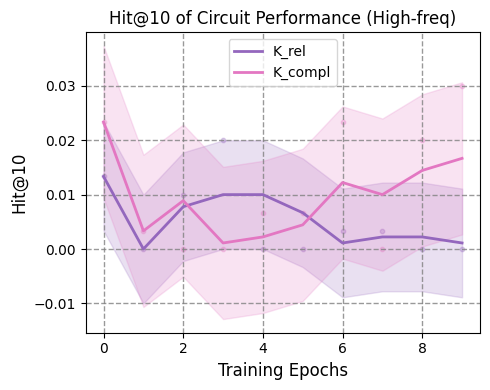

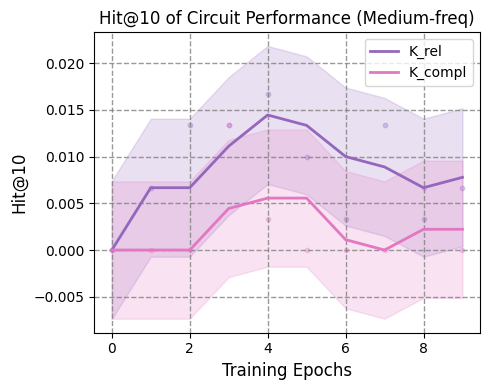

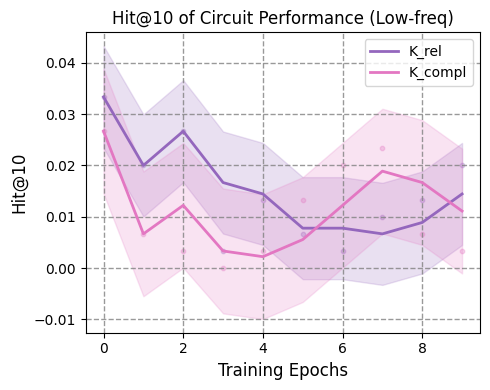

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(len(indexes))
for source_frequency in ["high", "medium", "low"]:
    plt.figure(figsize=(5, 4))
    color_cnt = 4
    for source_type in ["revised", "new"]:
        y = [0 for _ in range(len(indexes))]
        cnt = 0
        target_type = source_type
        target_frequency = source_frequency
        for i, hit_at_10 in enumerate(hit_at_10_results[source_type][source_frequency][target_type][target_frequency]):
            y[i] += hit_at_10
        cnt += 1
        # y += hit_at_10_results[source_type][source_frequency][target_type][target_frequency]

        y = [v / cnt for v in y]
        
        # # 定义核函数
        # kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))

        # # 拟合高斯过程回归模型
        # gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        # gp.fit(x[:, np.newaxis], y)

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)[:, np.newaxis]
        # y_fit, std_residuals = gp.predict(x_fit, return_std=True)

        # # 使用样条插值
        # spline = UnivariateSpline(x, y, s=1)  # s 控制平滑程度，越大越平滑

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)
        # y_fit = spline(x_fit)

        # # 计算残差并估算标准差
        # y_residuals = y - spline(x)
        # std_residuals = np.std(y_residuals)
        
        window_size = 3
        x_fit = x
        y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
        y_fit = np.array(y[:window_size-1] + y_fit.tolist())
        y_residuals = y - y_fit
        std_residuals = np.std(y_residuals)
        
        line, = plt.plot(x_fit.ravel(), y_fit, label=f'{k_type[source_type].capitalize()}', linewidth=2, color=f'C{color_cnt}')
        plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
        
        # 绘制阴影区域，偏离值区域
        plt.fill_between(x_fit.ravel(), y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)
        
        color_cnt += 2

    plt.title(f'Hit@10 of Circuit Performance ({source_frequency.capitalize()}-freq)', fontsize=12)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Hit@10', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

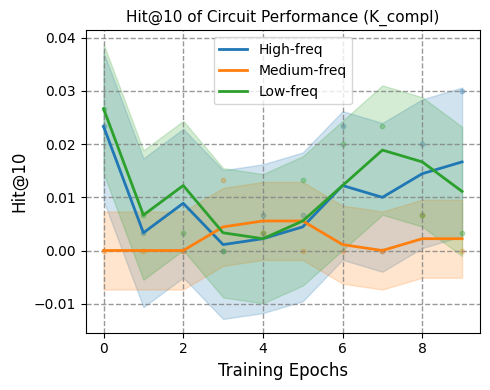

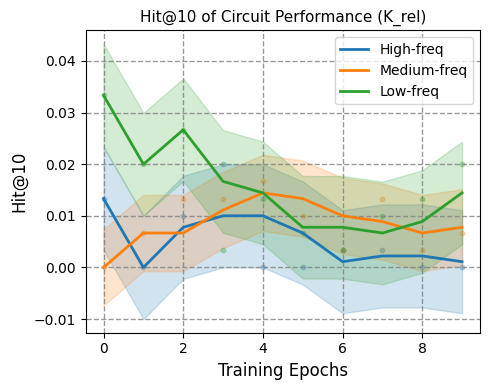

In [20]:
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(len(indexes))
for source_type in ["new", "revised"]:
    plt.figure(figsize=(5, 4))
    for source_frequency in ["high", "medium", "low"]:
        y = [0 for _ in range(len(indexes))]
        cnt = 0
        target_type = source_type
        target_frequency = source_frequency
        for i, hit_at_10 in enumerate(hit_at_10_results[source_type][source_frequency][target_type][target_frequency]):
            y[i] += hit_at_10
        cnt += 1
        # y += hit_at_10_results[source_type][source_frequency][target_type][target_frequency]

        y = [v / cnt for v in y]

        # # 使用样条插值
        # spline = UnivariateSpline(x, y, s=1)  # s 控制平滑程度，越大越平滑

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)
        # y_fit = spline(x_fit)

        # # 计算残差并估算标准差
        # y_residuals = y - spline(x)
        # std_residuals = np.std(y_residuals)
        
        window_size = 3
        x_fit = x
        y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
        y_fit = np.array(y[:window_size-1] + y_fit.tolist())
        y_residuals = y - y_fit
        std_residuals = np.std(y_residuals)

        line, = plt.plot(x_fit, y_fit, label=f'{source_frequency.capitalize()}-freq', linewidth=2)
        plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
        
        # 绘制阴影区域，偏离值区域
        plt.fill_between(x_fit, y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)

    plt.title(f'Hit@10 of Circuit Performance ({k_type[source_type]})', fontsize=11)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Hit@10', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [21]:
from collections import defaultdict

def create_performance_dict():
    return defaultdict(lambda: {"new": create_freq_dict(), "revised": create_freq_dict()})

def create_freq_dict():
    # 使用 lambda 递归创建嵌套字典结构
    return {"high": [], "medium": [], "low": []}

# 使用函数创建相同结构的嵌套字典
clean_baseline_performance = create_performance_dict()
circuit_performance = create_performance_dict()
corrupted_baseline_performance = create_performance_dict()
faithfulness_performance = create_performance_dict()
edge_entropy = create_performance_dict()
graph = create_performance_dict()

topn = 50000
circuit_n = 300
for index in tqdm(indexes):
    for task in ["city"]:
        for type in ["new", "revised"]:
            for freq in ["high", "medium", "low"]:
                result_file = os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_{topn}", f"{task}_results.json")
                if os.path.exists(result_file):
                    results = json.load(open(result_file))
                    clean_baseline_performance[task][type][freq].append(results["clean_baseline_performance"])
                    circuit_performance[task][type][freq].append(results["circuit_performance"])
                    corrupted_baseline_performance[task][type][freq].append(results["corrupted_baseline_performance"])
                    faithfulness = (results["circuit_performance"] - results["corrupted_baseline_performance"]) / (results["clean_baseline_performance"] - results["corrupted_baseline_performance"]) if results["clean_baseline_performance"] > results["corrupted_baseline_performance"] else 0
                    faithfulness_performance[task][type][freq].append(faithfulness)
                    edge_entropy[task][type][freq].append(results["edge_entropy"])
                    g = Graph.from_pt(os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_{topn}", f"{task}_graph.pt"))
                    graph[task][type][freq].append(g)
                else:
                    print(f"Result file '{result_file}' not found for directory '{subdirectories[index]}'")
                    clean_baseline_performance[task][type][freq].append(None)
                    circuit_performance[task][type][freq].append(None)
                    corrupted_baseline_performance[task][type][freq].append(None)
                    faithfulness_performance[task][type][freq].append(None)
                    edge_entropy[task][type][freq].append(None)
                    graph[task][type][freq].append(None)

  0%|          | 0/10 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/train/TinyLlama_v1.1/2024-12-20-09-42-42/checkpoints/checkpoint-400/circuit_300/type_new/frequency_high/method_EAP-IG/topn_50000/city_graph.pt'

In [19]:
def jaccard_similarity(a, b):
    """
    计算两个集合的 Jaccard 相似度。

    参数:
    - a: 集合 a
    - b: 集合 b

    返回:
    - Jaccard 相似度
    """
    set_a = set()
    for key, value in a.items():
        if value.in_graph:
             set_a.add(key)
    set_b = set()
    for key, value in b.items():
        if value.in_graph:
             set_b.add(key)
    return len(set_a & set_b) / len(set_a | set_b)

In [22]:
nodes_last_jaccard_similarity = create_performance_dict()
edges_last_jaccard_similarity = create_performance_dict()

for task in ["city"]:
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            for i in range(1, len(indexes)):
                nodes_last_jaccard_similarity[task][type][freq].append(jaccard_similarity(graph[task][type][freq][i-1].nodes, graph[task][type][freq][-1].nodes))
                edges_last_jaccard_similarity[task][type][freq].append(jaccard_similarity(graph[task][type][freq][i-1].edges, graph[task][type][freq][-1].edges))

In [23]:
title = "TinyLlama"

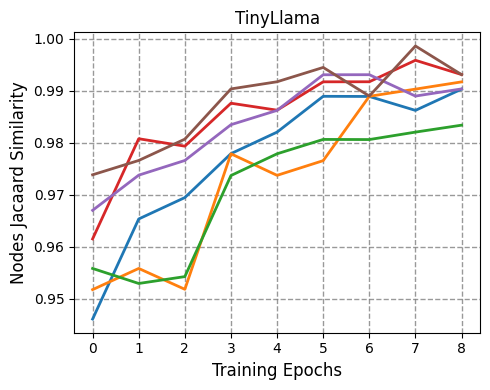

In [24]:
task = "city"

# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(nodes_last_jaccard_similarity[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, nodes_last_jaccard_similarity[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(title)
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Nodes Jacaard Similarity', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

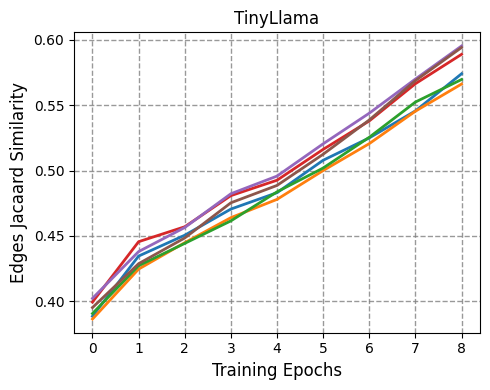

In [26]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(edges_last_jaccard_similarity[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, edges_last_jaccard_similarity[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(title)
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Edges Jacaard Similarity', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

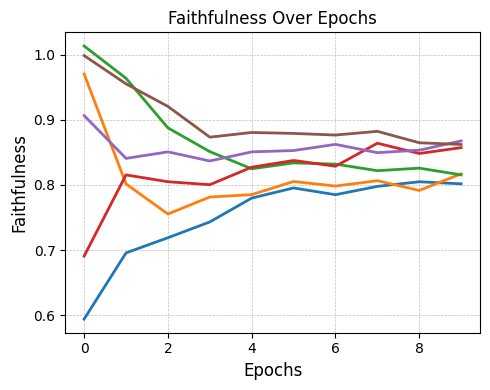

In [30]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(clean_baseline_performance[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, faithfulness_performance[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(f'Faithfulness Over Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Faithfulness', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

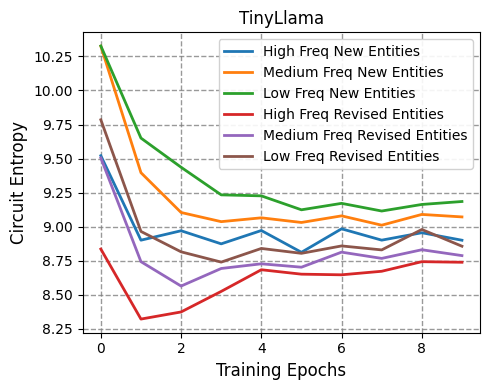

In [35]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(clean_baseline_performance[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, edge_entropy[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(title)
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Circuit Entropy', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [33]:
import math

def calculate_entropy(g):
    # 获取所有边的 score 绝对值
    scores = [abs(edge.score) for edge in g.edges.values() if edge.in_graph]
    
    # 如果没有有效的 score 值，返回 None
    if not scores:
        return None
    
    # 归一化 score 值以生成概率分布
    total_score = sum(scores)
    probabilities = [score / total_score for score in scores]

    # 根据 Shannon 公式计算熵
    edge_entropy = -sum(p * math.log(p) for p in probabilities if p > 0)
    
    return edge_entropy

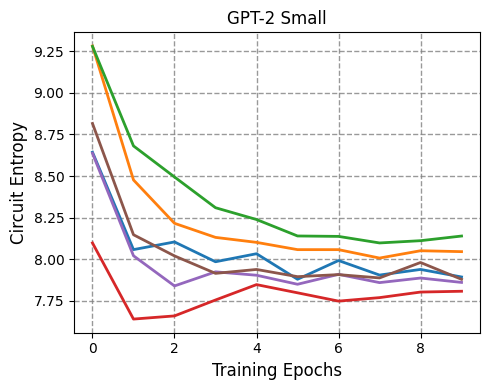

In [34]:
part_edge_entropy = create_performance_dict()
for task in ["city"]:
    # Set the figure size to increase x-axis width
    plt.figure(figsize=(5, 4))  # Adjust width and height as needed
    cnt = 0
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            for i in range(len(indexes)):
                part_edge_entropy[task][type][freq].append(calculate_entropy(graph[task][type][freq][i]))
            plt.plot(epochs, part_edge_entropy[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
            cnt += 1

    # Set titles and labels
    plt.title(title)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Circuit Entropy', fontsize=12)
    plt.legend(loc='best', frameon=True, framealpha=0.9)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

In [36]:
def count_edges_at_layers(g, activated=True):
    counter = [0 for i in range(g.cfg["n_layers"] )]
    for edge in g.edges.values():
        if activated and not edge.in_graph:
            continue
        counter[edge.parent.layer] += 1
    
    return counter

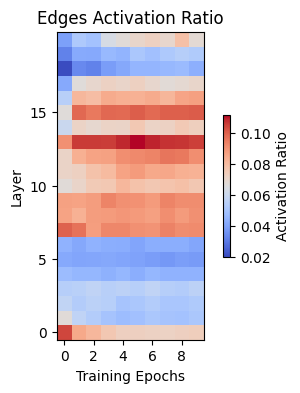

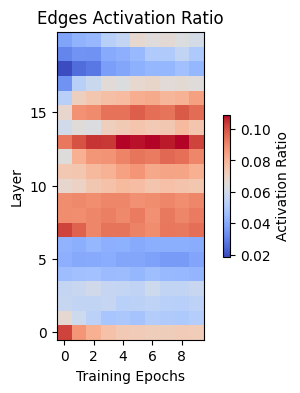

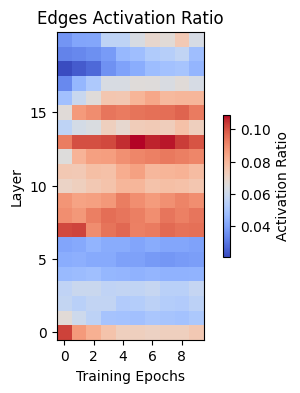

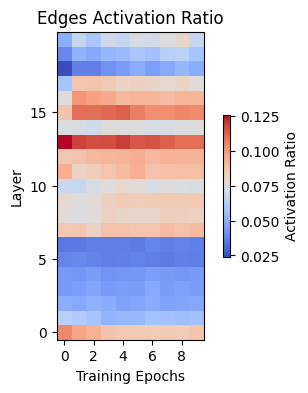

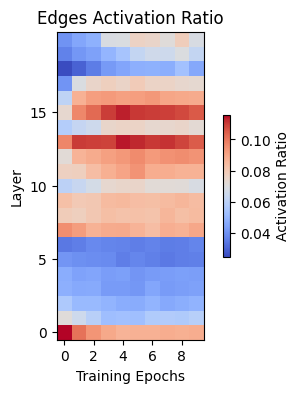

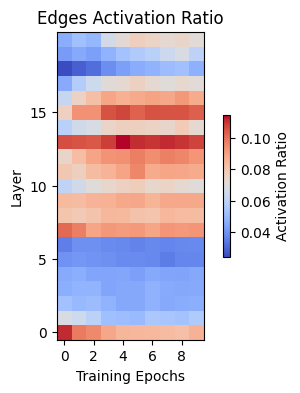

In [41]:
for task in ["city"]:
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            layer_distribution_matrix = []
            for i in range(len(indexes)):
                layer_distribution = np.array(count_edges_at_layers(graph[task][type][freq][i], activated=True)) / np.array(count_edges_at_layers(graph[task][type][freq][i], activated=False))
                layer_distribution_matrix.append(layer_distribution[:-1])

            layer_distribution_matrix = np.array(layer_distribution_matrix)

            # Set the figure size to increase x-axis width
            plt.figure(figsize=(5,4))  # Adjust width and height as needed

            im = plt.imshow(layer_distribution_matrix.T, cmap='coolwarm', interpolation='nearest')
            plt.title('Edges Activation Ratio')
            plt.ylabel('Layer')
            plt.xlabel('Training Epochs')
            cbar = plt.colorbar(im, shrink=0.46)
            cbar.set_label('Activation Ratio')
            # 反转 y 轴
            plt.gca().invert_yaxis()
            plt.yticks(np.arange(0, 20, 5))
            plt.xticks(np.arange(0, 10, 2))
            plt.show()